In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt
! kaggle datasets download -d anindya2906/english-to-french

 94% 123M/131M [00:01<00:00, 78.2MB/s] 
100% 131M/131M [00:01<00:00, 88.6MB/s]
 81% 5.00M/6.17M [00:00<00:00, 26.1MB/s]
100% 6.17M/6.17M [00:00<00:00, 29.2MB/s]


In [4]:
!unzip glove6b100dtxt.zip -d glove100
!unzip english-to-french.zip -d eng2french

Archive:  glove6b100dtxt.zip
  inflating: glove100/glove.6B.100d.txt  
Archive:  english-to-french.zip
  inflating: eng2french/_about.txt   
  inflating: eng2french/fra-eng/_about.txt  
  inflating: eng2french/fra-eng/fra.txt  
  inflating: eng2french/fra.txt      


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [36]:
max_seq_len = 100
max_vocab_size = 20000
epochs = 100
batch_size = 64
embedding_dim = 100
validation_split = 0.2
latent_dim = 256
num_samples = 2500

In [37]:
word_embeddings = {}
with open(os.path.join('/content/glove100/glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        
        word_embeddings[word_key] = word_vector

In [38]:
input_txts = []
target_input_maptxts = []
target_txts = []

In [39]:
idx = 0
special = u"\u202f"
for line in open('eng2french/fra-eng/fra.txt'):

  eng, fre = line.strip().replace(special, ' ').split('\t')
  
  input_txts.append(eng)
  target_input_maptxts.append('<sos> '+fre)
  target_txts.append(fre+' <eos>')

  idx += 1
  if idx == num_samples:
    break

In [40]:
tokenizer_eng = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size)
tokenizer_eng.fit_on_texts(input_txts)
input_sequences = tokenizer_eng.texts_to_sequences(input_txts)

In [41]:
word2index_eng = tokenizer_eng.word_index
num_words_eng = len(word2index_eng)
print(num_words_eng)

773


In [42]:
max_input_txt_len = max(len(s) for s in input_txts)
max_input_txt_len

12

In [43]:
tokenizer_fre = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, filters='')
tokenizer_fre.fit_on_texts(target_input_maptxts+target_txts)
target_sequences = tokenizer_fre.texts_to_sequences(target_txts)
target_input_map_sequences = tokenizer_fre.texts_to_sequences(target_input_maptxts)

In [44]:
max_target_txt_len = max(len(s) for s in target_txts)
max_target_txt_len

43

In [45]:
word2index_fre = tokenizer_fre.word_index
num_words_fre = len(word2index_fre)
print(num_words_fre)

1881


In [46]:
num_words_fre = min(num_words_fre+1, max_vocab_size)
num_words_eng = min(num_words_eng+1, max_vocab_size)

In [47]:
assert '<sos>' in word2index_fre
assert '<eos>' in word2index_fre

In [48]:
target_txts[:20]

['Va ! <eos>',
 'Cours ! <eos>',
 'Courez ! <eos>',
 'Au feu ! <eos>',
 "À l'aide ! <eos>",
 'Saute. <eos>',
 'Ça suffit ! <eos>',
 'Stop ! <eos>',
 'Arrête-toi ! <eos>',
 'Attends ! <eos>',
 'Attendez ! <eos>',
 'Poursuis. <eos>',
 'Continuez. <eos>',
 'Poursuivez. <eos>',
 'Je comprends. <eos>',
 "J'essaye. <eos>",
 "J'ai gagné ! <eos>",
 "Je l'ai emporté ! <eos>",
 'Oh non ! <eos>',
 'Attaque ! <eos>']

In [49]:
encoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_input_txt_len, padding='pre')
decoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(target_input_map_sequences, maxlen=max_target_txt_len, padding='post')
decoder_targets = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_target_txt_len, padding='post')

In [50]:
num_words_inputs = min(max_vocab_size, len(word2index_eng)+1)
num_words_inputs

774

In [51]:
embedding_matrix = np.zeros((num_words_inputs, embedding_dim))
for word, idx in word2index_eng.items():
    if idx < max_vocab_size:
        embedding_vector = word_embeddings.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [52]:
print(f'Encoder Input Sequences shape: {encoder_inputs.shape}')
print(f'Decoder Input Sequences shape: {decoder_inputs.shape}')
print(f'Deocder Target Sequences shape: {decoder_targets.shape}')

Encoder Input Sequences shape: (2500, 12)
Decoder Input Sequences shape: (2500, 43)
Deocder Target Sequences shape: (2500, 43)


In [53]:
one_hot_targets = np.zeros((len(decoder_targets), max_target_txt_len, num_words_fre))
for i, target_sequence in enumerate(decoder_targets):
  for j, token_id in enumerate(target_sequence):
      if token_id > 0:
        one_hot_targets[i, j, token_id] = 1

one_hot_targets.shape

(2500, 43, 1882)

In [54]:
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words_eng, output_dim=embedding_dim, weights=[embedding_matrix] ,input_length=max_input_txt_len)

input_ = tf.keras.Input(shape=(max_input_txt_len,))
x = embedding_layer(input_)

encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_output, encoder_h, encoder_c = encoder_lstm(x)

encoder_states = [encoder_h, encoder_c]

decoder_input_ = tf.keras.Input(shape=[max_target_txt_len,])
decoder_embedding = tf.keras.layers.Embedding(input_dim=num_words_fre, output_dim=embedding_dim)
decoder_x = decoder_embedding(decoder_input_)

decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_lstm_output, _, _ = decoder_lstm(decoder_x, initial_state=encoder_states)

dense = tf.keras.layers.Dense(units=num_words_fre, activation='softmax')
output_ = dense(decoder_lstm_output)

model = tf.keras.models.Model(inputs=[input_, decoder_input_], outputs=output_)

In [55]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=[encoder_inputs, decoder_inputs], y=one_hot_targets, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/100
32/32 [==============================] - 4s 53ms/step - loss: 0.5357 - accuracy: 0.0225 - val_loss: 0.5637 - val_accuracy: 0.0233
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 0.5066 - accuracy: 0.0255 - val_loss: 0.5728 - val_accuracy: 0.0289
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 0.5046 - accuracy: 0.0277 - val_loss: 0.5627 - val_accuracy: 0.0330
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.5016 - accuracy: 0.0279 - val_loss: 0.5685 - val_accuracy: 0.0330
Epoch 5/100
32/32 [==============================] - 1s 30ms/step - loss: 0.4994 - accuracy: 0.0279 - val_loss: 0.5583 - val_accuracy: 0.0330
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.4965 - accuracy: 0.0279 - val_loss: 0.5602 - val_accuracy: 0.0330
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.4939 - accuracy: 0.0279 - val_loss: 0.5567 - val_accuracy: 0.0330
Epoch 

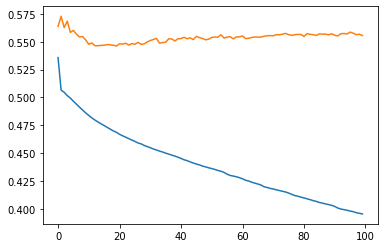

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

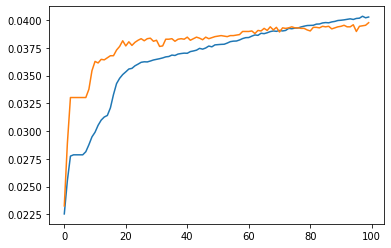

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [58]:
encoder_context_model = tf.keras.Model(input_, encoder_states)

context_h = tf.keras.Input(shape=(latent_dim,))
context_c = tf.keras.Input(shape=(latent_dim,))
context_vector = [context_h, context_c]

decoder_input_single = tf.keras.Input(shape=(1,))
decoder_single_x = decoder_embedding(decoder_input_single)

decoder_single_output, single_h, single_c = decoder_lstm(decoder_single_x, initial_state=context_vector)
decoder_states = [single_h, single_c]
output_single = dense(decoder_single_output)

predict_model = tf.keras.models.Model(inputs=[decoder_input_single]+context_vector, outputs=[output_single]+decoder_states)

In [59]:
index2word_eng = {v:k for k,v in word2index_eng.items()}
index2word_fre = {v:k for k,v in word2index_fre.items()}

In [60]:
word2index_fre['<eos>']

2

In [61]:
def decode_english_to_french(eng_seq):

  final_seq = []
  encoder_context_states = encoder_context_model.predict(eng_seq)
  target_seq = np.array([[word2index_fre['<sos>']]])
  eos = word2index_fre['<eos>']
  print(eos)

  for _ in range(max_target_txt_len):
    decoder_o, h, c = predict_model.predict([target_seq]+encoder_context_states)

    fre_word = np.argmax(decoder_o[0,0,:])
    print(fre_word)
    if fre_word == eos:
      break
    
    if fre_word > 0:
      final_seq.append(index2word_fre.get(fre_word))
      
    target_seq[0,0] = fre_word
    encoder_context_states = [h, c]

  return ' '.join(final_seq)

In [62]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_txts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_english_to_french(input_seq)
  print('-')
  print('Input:', input_txts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

2
3
2
-
Input: I'll stop.
Translation: je
Continue? [Y/n]y
2
8
2
-
Input: Pick a date.
Translation: c'est
Continue? [Y/n]y
2
3
5
2
-
Input: I'm frantic.
Translation: je suis
Continue? [Y/n]y
2
9
2
-
Input: He squinted.
Translation: il
Continue? [Y/n]y
2
33
2
-
Input: Get to bed.
Translation: va
Continue? [Y/n]y
2
9
11
2
-
Input: It's night.
Translation: il est
Continue? [Y/n]y
2
3
5
2
-
Input: I'm 17, too.
Translation: je suis
Continue? [Y/n]n
